# Inferring the space-dependent reaction rate in a diffusion-reaction system


## The problem we need to solve


We consider a one-dimensional diffusion-reaction system in which the reaction rate $k(x)$ is a space-dependent function:

$$\lambda\frac{\partial^2u}{\partial x^2}-k(x)u=f,\quad x\in[0,1],$$

where $\lambda=0.01$ is the diffusion coefficient, $u$ is the solute concentration, and $f=\sin(2\pi x)$ is the source term.
The objective is to infer $k(x)$ given measurements on $u.$ The exact unknown reaction rate is

$$k(x)=0.1+\exp\left[-0.5\frac{(x-0.5)^2}{0.15^2}\right].$$

In addition, the condition $u(x)=0$ is imposed at $x=0$ and 1.


## Dimensional analysis

Below is a dimensional analysis for each variable and parameter in the given one-dimensional diffusion-reaction equation:

**Governing equation:**
$$
\lambda \frac{\partial^2 u}{\partial x^2} - k(x)u = f, \quad x \in [0,1].
$$

**Physical meanings and typical dimensions:**

1. **Spatial coordinate, $ x $**  
   - Typically, a spatial coordinate has the dimension of length:

     $$
     [x] = L.
     $$

2. **Solute concentration, $ u(x) $**  
   - Concentration is commonly expressed as mass per unit volume (assuming a mass-based concentration):  

     $$
     [u] = M / L^3.
     $$

3. **Diffusion coefficient, $ \lambda $**  
   - A diffusion coefficient typically has dimensions of length squared per time:  

     $$
     [\lambda] = L^2 / T.
     $$

4. **Reaction rate, $ k(x) $**  
   - Consider the term $ k(x)u $. This must have the same dimension as $\lambda \frac{\partial^2 u}{\partial x^2}$.  
   - The Laplacian term $\frac{\partial^2 u}{\partial x^2}$ has dimension $(M/L^3) / L^2 = M / (L^5)$.  
   - Multiplying by $\lambda = L^2/T$ gives $(L^2/T)*(M/L^5) = M/(T L^3)$.  
   - Therefore, $k(x)u$ must also have dimension $M/(T L^3)$. Given $ [u] = M/L^3 $, it follows:  

     $$
     [k(x)] [u] = M/(T L^3) \implies [k(x)] (M/L^3) = M/(T L^3) \implies [k(x)] = 1/T.
     $$

   Thus, the reaction rate $k(x)$ has units of inverse time, which makes sense physically.

5. **Source term, $ f $**  
   - The source term $ f $ appears on the right-hand side of the equation and must have the same dimension as the left-hand side terms. We have already found that $\lambda \frac{\partial^2 u}{\partial x^2}$ and $k(x)u$ both have dimensions $ M/(T L^3) $. Hence:
   
     $$
     [f] = M/(T L^3).
     $$

**Summary of Dimensions:**
- $[x] = L$
- $[u] = M/L^3$
- $[\lambda] = L^2/T$
- $[k(x)] = 1/T$
- $[f] = M/(T L^3)$

These dimensions are consistent with a diffusion-reaction system where:
- $u$ is a concentration (mass per volume),
- $\lambda$ is a diffusion coefficient (length²/time),
- $k(x)$ is a reaction rate (1/time),
- $f$ is a source term with the dimension of a generation/consumption rate of mass per volume per time.

## Implementation


First, import the necessary libraries:



In [1]:
import brainstate as bst
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_bvp

from deepxde import pinnx


Define the units for the variables and parameters:

In [2]:
unit_of_x = u.meter
unit_of_u = u.mole / u.meter ** 3
unit_of_f = u.mole / (u.second * u.meter ** 3)

l = 0.01 * unit_of_x ** 2 / u.second


Define the solution for the solute concentration:

In [3]:

def k(x):
    return 0.1 + np.exp(-0.5 * (x - 0.5) ** 2 / 0.15 ** 2)


def fun(x, y):
    return np.vstack((y[1], (k(x) * y[0] + np.sin(2 * np.pi * x)) / l.mantissa))


def bc(ya, yb):
    return np.array([ya[0], yb[0]])


num = 100
xvals = np.linspace(0, 1, num)
y = np.zeros((2, xvals.size))
res = solve_bvp(fun, bc, xvals, y)


Define the PDE for the neural network model:

In [4]:
geom = pinnx.geometry.Interval(0, 1).to_dict_point(x=unit_of_x)


def pde(x, y):
    hessian = net.hessian(x, y='u')
    du_xx = hessian["u"]["x"]["x"]
    f = u.math.sin(2 * np.pi * x['x'].mantissa) * unit_of_f
    return l * du_xx - y['u'] * y['k'] - f

Define the neural network model:

In [5]:
net = pinnx.nn.Model(
    pinnx.nn.DictToArray(x=unit_of_x),
    pinnx.nn.PFNN([1, [20, 20], [20, 20], 2], "tanh", bst.init.KaimingUniform()),
    pinnx.nn.ArrayToDict(u=unit_of_u, k=1 / u.second),
)

Define the training data:

In [6]:
def gen_traindata():
    x = {'x': xvals * unit_of_x}
    y = {'u': res.sol(xvals)[0] * unit_of_u}
    return x, y


ob_x, ob_u = gen_traindata()
observe_u = pinnx.icbc.PointSetBC(ob_x, ob_u)

Define the boundary conditions:

In [7]:
bc = pinnx.icbc.DirichletBC(lambda x: {'u': 0 * unit_of_u})


Define the PDE problem:

In [8]:
problem = pinnx.problem.PDE(
    geom,
    pde,
    constraints=[bc, observe_u],
    approximator=net,
    num_domain=50,
    num_boundary=8,
    train_distribution="uniform",
    num_test=1000,
)

Train the model:

In [9]:
model = pinnx.Trainer(problem)
model.compile(bst.optim.Adam(1e-3)).train(iterations=20000)


Compiling trainer...
'compile' took 0.046593 s

Training trainer...

Step      Train loss                                                                         Test loss                                                                          Test metric 
0         [0.42841953 * 10.0^0 * (meter2 / second * (mmolar / meter) / meter) ** 2,          [0.48738545 * 10.0^0 * (meter2 / second * (mmolar / meter) / meter) ** 2,          []          
           {'ibc0': {'u': 0.04377487 * mmolar}},                                              {'ibc0': {'u': 0.04377487 * mmolar}},                                                         
           {'ibc1': {'u': 0.76479465 * mmolar}}]                                              {'ibc1': {'u': 0.76479465 * mmolar}}]                                                         
1000      [0.00161212 * 10.0^0 * (meter2 / second * (mmolar / meter) / meter) ** 2,          [0.00137106 * 10.0^0 * (meter2 / second * (mmolar / meter) / meter) ** 2,         

Verify the results:

l2 relative error for k: 0.030291751


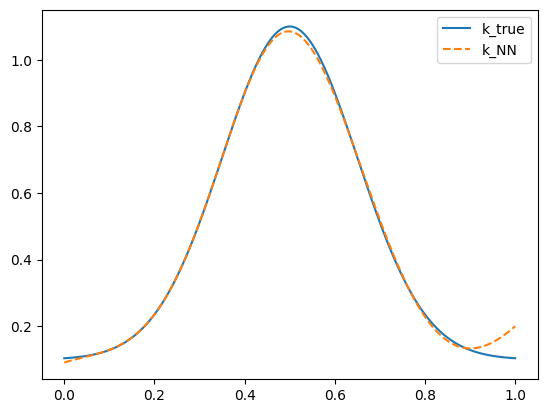

l2 relative error for u: 0.00095011527


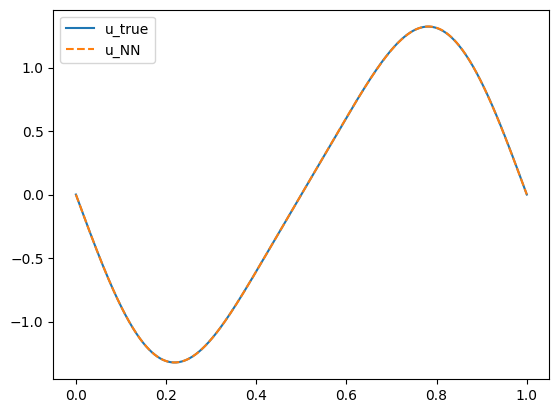

In [10]:
x = geom.uniform_points(500)
yhat = model.predict(x)
uhat, khat = yhat['u'].mantissa, yhat['k'].mantissa
x = x['x'].mantissa

ktrue = k(x)
print("l2 relative error for k: " + str(pinnx.metrics.l2_relative_error(khat, ktrue)))

plt.figure()
plt.plot(x, ktrue, "-", label="k_true")
plt.plot(x, khat, "--", label="k_NN")
plt.legend()
plt.show()

utrue = res.sol(x)[0]
print("l2 relative error for u: " + str(pinnx.metrics.l2_relative_error(uhat, utrue)))

plt.figure()
plt.plot(x, utrue, "-", label="u_true")
plt.plot(x, uhat, "--", label="u_NN")
plt.legend()
plt.show()